# Imports

In [14]:
import numpy as np
import pandas as pd
import os

import scipy.io    # Scipy Module that deals with input/output
from skimage.transform import resize   # Image Processing Library
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc    # Garbage Collector
gc.collect()

import os

# Pytorch

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange

In [2]:
# Input data files (2015_BOE_Chiu) are available in the "../data/" directory.
print(os.listdir("../data"))

['2015_boe_chiu', 'FashionMNIST', 'mnist_test.csv', 'mnist_test_anom.csv', 'mnist_test_anom_only_8.csv', 'mnist_train.csv']


# Data Preprocessing

In [3]:
# Data Path Setting

input_path = os.path.join('..', 'data', '2015_boe_chiu', '2015_BOE_Chiu')

subject_path = (
    [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] +
    [os.path.join(input_path, 'Subject_10.mat')]
)

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

In [4]:
subject_path

['..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_01.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_02.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_03.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_04.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_05.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_06.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_07.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_08.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_09.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_10.mat']

In [5]:
mat = scipy.io.loadmat(subject_path[0])   # Load Matlab file
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

In [6]:
img_tensor.shape

(496, 768, 61)

In [7]:
img_array.shape

(61, 496, 768)

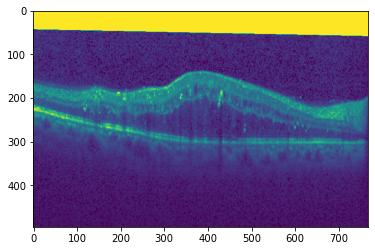

In [8]:
plt.imshow(img_array[25]);

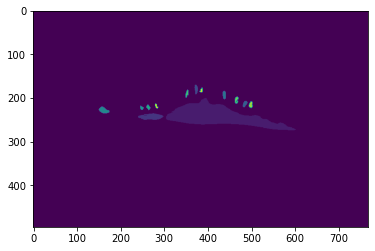

In [9]:
plt.imshow(manual_fluid_array[25]);

In [10]:
# Functions for Data Preprocessing

def thresh(x):
    if x == 0:
        return 0
    else:
        return 1
    
thresh = np.vectorize(thresh, otypes=[float]) 

# otypes = output type
# class numpy.vectorize(pyfunc, otypes=None, doc=None, excluded=None, cache=False, signature=None)

def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255   # Normalization
        img_array = resize(img_array, (img_array.shape[0], width, height))   # Image Resize
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

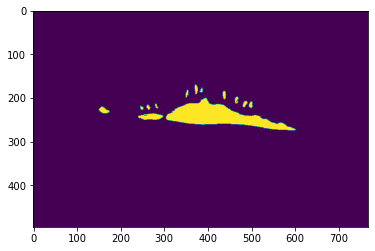

In [27]:
# Demonstration of thresh(x)  ==> y or label
plt.imshow(thresh(manual_fluid_array[25]));

# Preparation of Train and Validation Set

In [12]:
x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.91s/it]


In [13]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 284, 284), (99, 1, 196, 196), (11, 1, 284, 284), (11, 1, 196, 196))

# Unet Setup

In [15]:
use_gpu = torch.cuda.is_available()

In [18]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ConvTranspose2d(in_channels=mid_channel, 
                                     out_channels=out_channels, 
                                     kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        return block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2   # Calculate by how much the bypass should be decreased
            bypass = F.pad(bypass, (-c, -c, -c, -c))   # Reduces the bypass by padding -c
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        ##print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, bottleneck1.shape)
        ##print('Decode Block 3')
        ##print(bottleneck1.shape, encode_block3.shape)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        ##print(decode_block3.shape)
        ##print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        ##print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        ##print(cat_layer1.shape, encode_block1.shape)
        ##print('Final Layer')
        ##print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        ##print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        ##print(final_layer.shape)
        return  final_layer

# Model Training

In [19]:
learning_rate = 0.01
unet = UNet(in_channel=1, out_channel=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr=learning_rate, momentum=0.99)

In [20]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)  
    labels = labels.resize(batch_size*width_out*height_out)   # Resize to 1D
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [22]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [23]:
batch_size = 9
epochs = 1000
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [24]:
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)  # Calculate # of iteration based on batch size
t = trange(epochs, leave=True)   # leave=True : leaves progress bar upon termination of iteration
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\johnw\miniconda3\envs\575\lib\site-packages\torch\_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 10%|████████▎                                                                          | 1/10 [00:16<02:32, 16.96s/it]

Total loss in epoch 1 : 0.7368072271347046 and validation loss : 0.5952604413032532


 20%|████████████████▌                                                                  | 2/10 [00:25<01:36, 12.04s/it]

Total loss in epoch 2 : 0.6884781718254089 and validation loss : 0.4722144901752472


 30%|████████████████████████▉                                                          | 3/10 [00:34<01:14, 10.62s/it]

Total loss in epoch 3 : 0.6901395320892334 and validation loss : 0.395010381937027


 40%|█████████████████████████████████▏                                                 | 4/10 [00:43<01:00, 10.07s/it]

Total loss in epoch 4 : 0.6919789910316467 and validation loss : 0.38153794407844543


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:53<00:49,  9.87s/it]

Total loss in epoch 5 : 0.6806861162185669 and validation loss : 0.42677950859069824


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:02<00:39,  9.77s/it]

Total loss in epoch 6 : 0.6663961410522461 and validation loss : 0.5130656361579895


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:12<00:29,  9.72s/it]

Total loss in epoch 7 : 0.6664329767227173 and validation loss : 0.5974895358085632


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:21<00:19,  9.67s/it]

Total loss in epoch 8 : 0.6778426170349121 and validation loss : 0.6265718340873718


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:31<00:09,  9.64s/it]

Total loss in epoch 9 : 0.6842883229255676 and validation loss : 0.5846497416496277


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.11s/it]

Total loss in epoch 10 : 0.6830435395240784 and validation loss : 0.5084518194198608


In [25]:
gc.collect()

0

# Evaluation

In [28]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

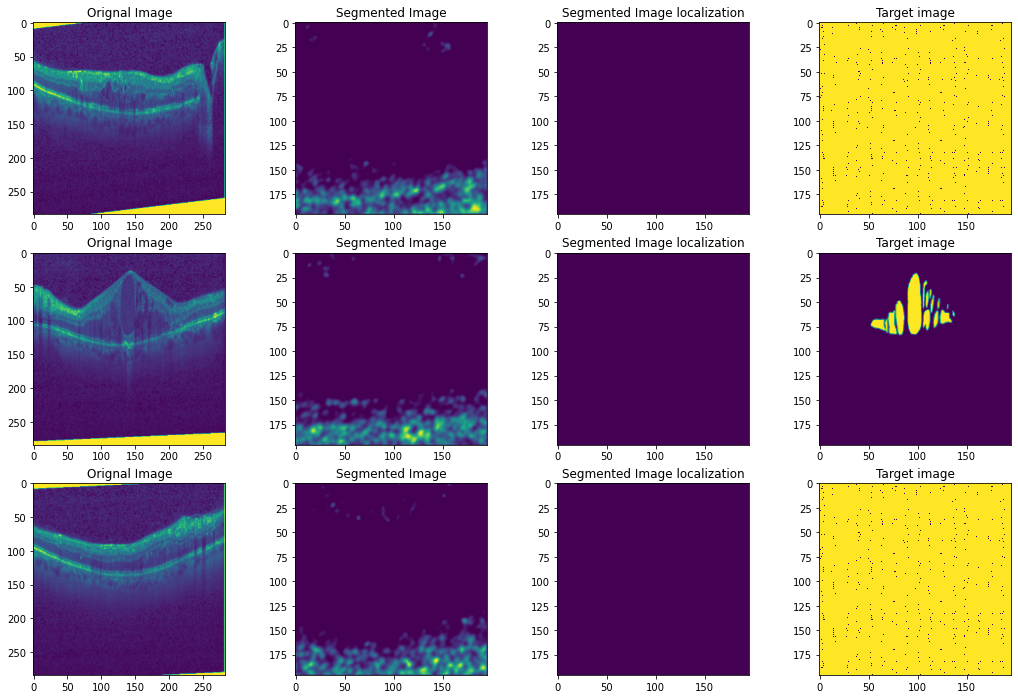

In [29]:
plot_examples(x_train, y_train)

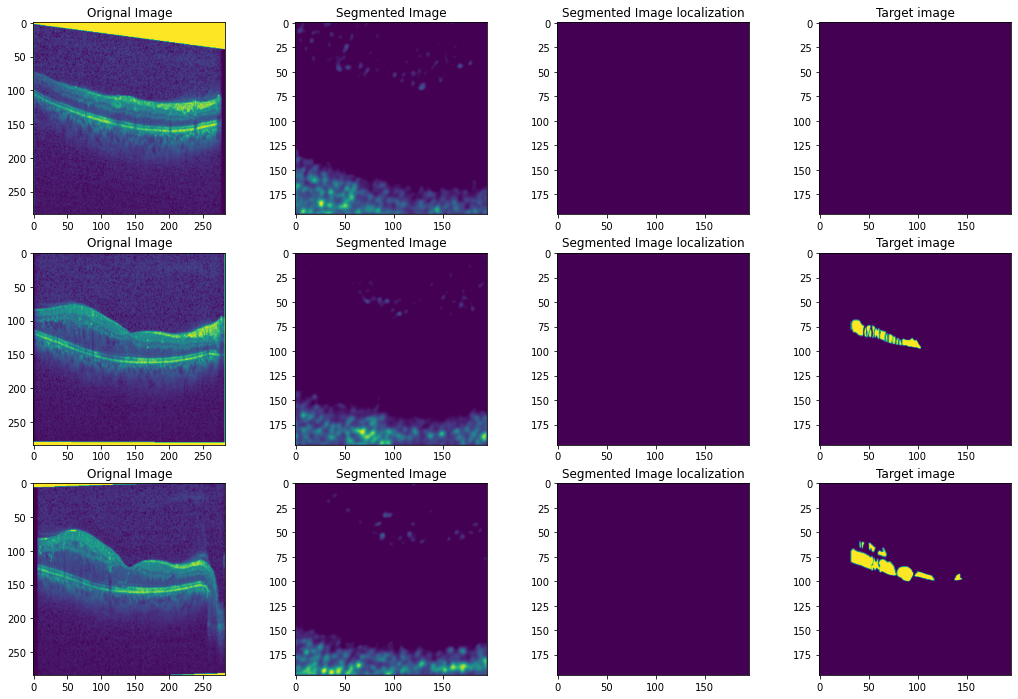

In [30]:
plot_examples(x_val, y_val)

In [ ]:
torch.save(unet.state_dict(), 'unet.pt')